## Preparation ##

On this step I download data and unzip it into predefined directory.
The result is list of extracted files.
This is one time operation.

In [ ]:
import urllib
import os
import tarfile

dataSetURL = 'https://d396qusza40orc.cloudfront.net/dataminingcapstone/YelpDataset/yelp_dataset.tar.gz'

fileName = 'yelp_dataset.tar.gz'
basePath = 'dataminingcapstone-001'
workingDir = os.path.join(os.curdir, basePath)

if not os.path.exists(workingDir):
    os.makedirs(workingDir)
    
path = os.path.join(workingDir, fileName)

urllib.urlretrieve(dataSetURL, path)
 
with tarfile.open(path, 'r:gz') as f:
    f.extractall(workingDir)
    
os.listdir(workingDir)

## Data loading ##
On this step I load oringinal json file as Apache Spark DataFrame (https://spark.apache.org/docs/latest/sql-programming-guide.html).

In [2]:
from pyspark.sql import SQLContext

basePath = 'dataminingcapstone-001'
workingDir = os.path.join(os.curdir, basePath)

sqlContext = SQLContext(sc)

targetDir = os.path.join(workingDir, 'yelp_dataset_challenge_academic_dataset')

reviewsJSON = os.path.join(targetDir, 'yelp_academic_dataset_review.json')
reviewsDF = sqlContext.read.json(reviewsJSON)

Check what is the schema of the provided file.

In [2]:
reviewsDF.printSchema()

root
 |-- business_id: string (nullable = true)
 |-- date: string (nullable = true)
 |-- review_id: string (nullable = true)
 |-- stars: long (nullable = true)
 |-- text: string (nullable = true)
 |-- type: string (nullable = true)
 |-- user_id: string (nullable = true)
 |-- votes: struct (nullable = true)
 |    |-- cool: long (nullable = true)
 |    |-- funny: long (nullable = true)
 |    |-- useful: long (nullable = true)



## Model extracting ##
On this step we select from the whole DataFrame only text column and pass through mapping to get in th result the iterator of texts across all prodided reviews.

It is necessary to notice that we don't load all texts into memory because it needs a significant much memery (especially in python) to keep it. Instead we use iterator.

In [76]:
allRewiews = reviewsDF.select("text").map(lambda x: x.text).toLocalIterator()

The obtained iterator we use as a source for TF-IDF vector extractor from Scikit-Learn library. This implementation includes also built-in stop words filter for English language. We're going to use multi-core implmentation of LDA model from python gensim package (https://radimrehurek.com/gensim/models/ldamulticore.html#module-gensim.models.ldamulticore).  

The function below is an ancupsulation of these two step and it takes an iterator of documents 'docs' and return LDA-model.

In [49]:
from gensim.matutils import Sparse2Corpus
from gensim.models.ldamulticore import LdaMulticore
from sklearn.feature_extraction.text import TfidfVectorizer

def buildLDA(docs, num_features=None, num_topics=100):
    vectorizer = TfidfVectorizer(max_df=0.5, max_features=num_features, min_df=2, stop_words='english', use_idf=True)
    vector = vectorizer.fit_transform(docs)
    
    id2words ={i:word for i,word in enumerate(vectorizer.get_feature_names())}
    
    corpus = Sparse2Corpus(vector,  documents_columns=False)
    lda = LdaMulticore(corpus, num_topics=num_topics, id2word=id2words)
    
    return lda

Now it's time to apply the created function and build LDA for 100 topics.

In [78]:
allReviewsLDA = buildLDA(allRewiews)

## Visualization ## 
Now it's time to work hard and prepare a tree of topics and words.
And we start it with a special class that wrap many configuration that we have to do to draw our visualization using graph_tool library (https://graph-tool.skewed.de/)

In [9]:
import math
import graph_tool.all as gt

class Visualization:
    'class to aggregate fine tuning of graph_tool'
    
    color_map = {0: [0.2, 0.2, 0.2, 0.2], 1: [0.3, 0.2, 0.7, 0.2], 2: [0.3, 0.2, 0.2, 0.7],
            3: [0.4, 0.7, 0.7, 0.2], 4: [0.4, 0.2, 0.7, 0.7], 5: [0.4, 0.7, 0.2, 0.7],
            6: [0.4, 0.0, 0.0, 0.5], 7: [0.4, 0.5, 0.0, 0.5], 8: [0.4, 0.5, 0.5, 0.1],
            9: [0.5, 0.7, 0.7, 0.7]}
    
    def __init__(self, root_label="all reviews", term_count=100, 
                 root_color=[0.640625, 0, 0, 0.9], root_font_size=18):
        self.g = gt.Graph()
        
        self.vprop_label = self.g.new_vertex_property("string")
        self.text_position = self.g.new_vertex_property("float")
        self.text_rotation = self.g.new_vertex_property("float")
        self.fill_color = self.g.new_vertex_property("vector<float>")
        self.font_size = self.g.new_vertex_property("int")
        self.vertex_size = self.g.new_vertex_property("int")
        self.marker_size = self.g.new_edge_property("float")
        self.text_offset = self.g.new_vertex_property("vector<float>")

        self.root = self.g.add_vertex()
        self.vprop_label[self.root] = root_label
        self.text_position[self.root] = -1
        self.text_rotation[self.root] = 0
        self.fill_color[self.root] = root_color
        self.font_size[self.root] = root_font_size
        self.text_offset[self.root] = [0.0, 0.0]
        
        self.angle = 0.0
        self.position = 0.0
        self.first_turn = True
        self.cur_text_offset = [-0.07, 0.0]
        self.topic_idx = 0
        self.cur_term_color = Visualization.color_map[0]
        
        self.angle_step = 2 * math.pi / term_count
    
    def add_topic(self, label, root=None, vcolor=[0.4, 0, 0, 0.9], voffset=[0.0, 0.0], 
                  emarker_size=2.0, vfont_size=16):
        vtopic = self.g.add_vertex()
        
        self.vprop_label[vtopic] = label
        self.text_position[vtopic] = -1
        self.text_rotation[vtopic] = 0
        self.fill_color[vtopic] = vcolor
        self.font_size[vtopic] = vfont_size
        self.text_offset[vtopic] = voffset
    
        if root == None:
            root = self.root
            
        e = self.g.add_edge(root, vtopic)
        self.marker_size[e] = emarker_size
        
        self.cur_term_color = Visualization.color_map[self.topic_idx % 10]
        self.topic_idx += 1
        
        return vtopic
    
    def add_term(self, vtopic, term, vfont_size=20, emarker_size=1.0, weight=1.0, vertex_size=50):
        vterm = self.g.add_vertex()
        self.vprop_label[vterm] = term.encode('utf8')
        self.text_position[vterm] = self.position
        self.text_rotation[vterm] = self.angle
        
        self.fill_color[vterm] = self.cur_term_color
        self.fill_color[vterm][3] *= weight 
        
        self.font_size[vterm] = vfont_size
        self.text_offset[vterm] = self.cur_text_offset
        
        self.text_offset[vterm][0] *= vertex_size / 50.0
        self.text_offset[vterm][1] *= vertex_size / 50.0
        
        self.vertex_size[vterm] = vertex_size
                     
        et = self.g.add_edge(vtopic, vterm)
        self.marker_size[et] = emarker_size
        
        self.increaseAngle(vertex_size)
        
    def increaseAngle(self, vertex_size):
        self.angle += self.angle_step

        if self.angle > math.pi / 2.0: 
            if self.first_turn:
                self.angle *= -1.0
                self.position = math.pi
                self.first_turn = False
                self.cur_text_offset = [0.07, 0.0]
            else:
                self.angle *= -1
                self.position = 0
                self.cur_text_offset = [-0.07, 0.0]

        
    def draw(self, file_name, output_size=(1980, 1980)): 
        pos = gt.radial_tree_layout(self.g, self.root)
        
        gt.graph_draw(self.g, vertex_text=self.vprop_label, vertex_text_position=self.text_position,\
                      vertex_text_rotation=self.text_rotation, vertex_fill_color=self.fill_color,\
                      output=file_name, output_size=output_size, inline=True, vertex_font_size=self.font_size,\
                      edge_marker_size=self.marker_size, vertex_text_offset=self.text_offset,\
                      vertex_size=self.vertex_size, pos=pos, fit_view=0.9)

Now everything is ready to display a tree of topics-terms based on all reviews.

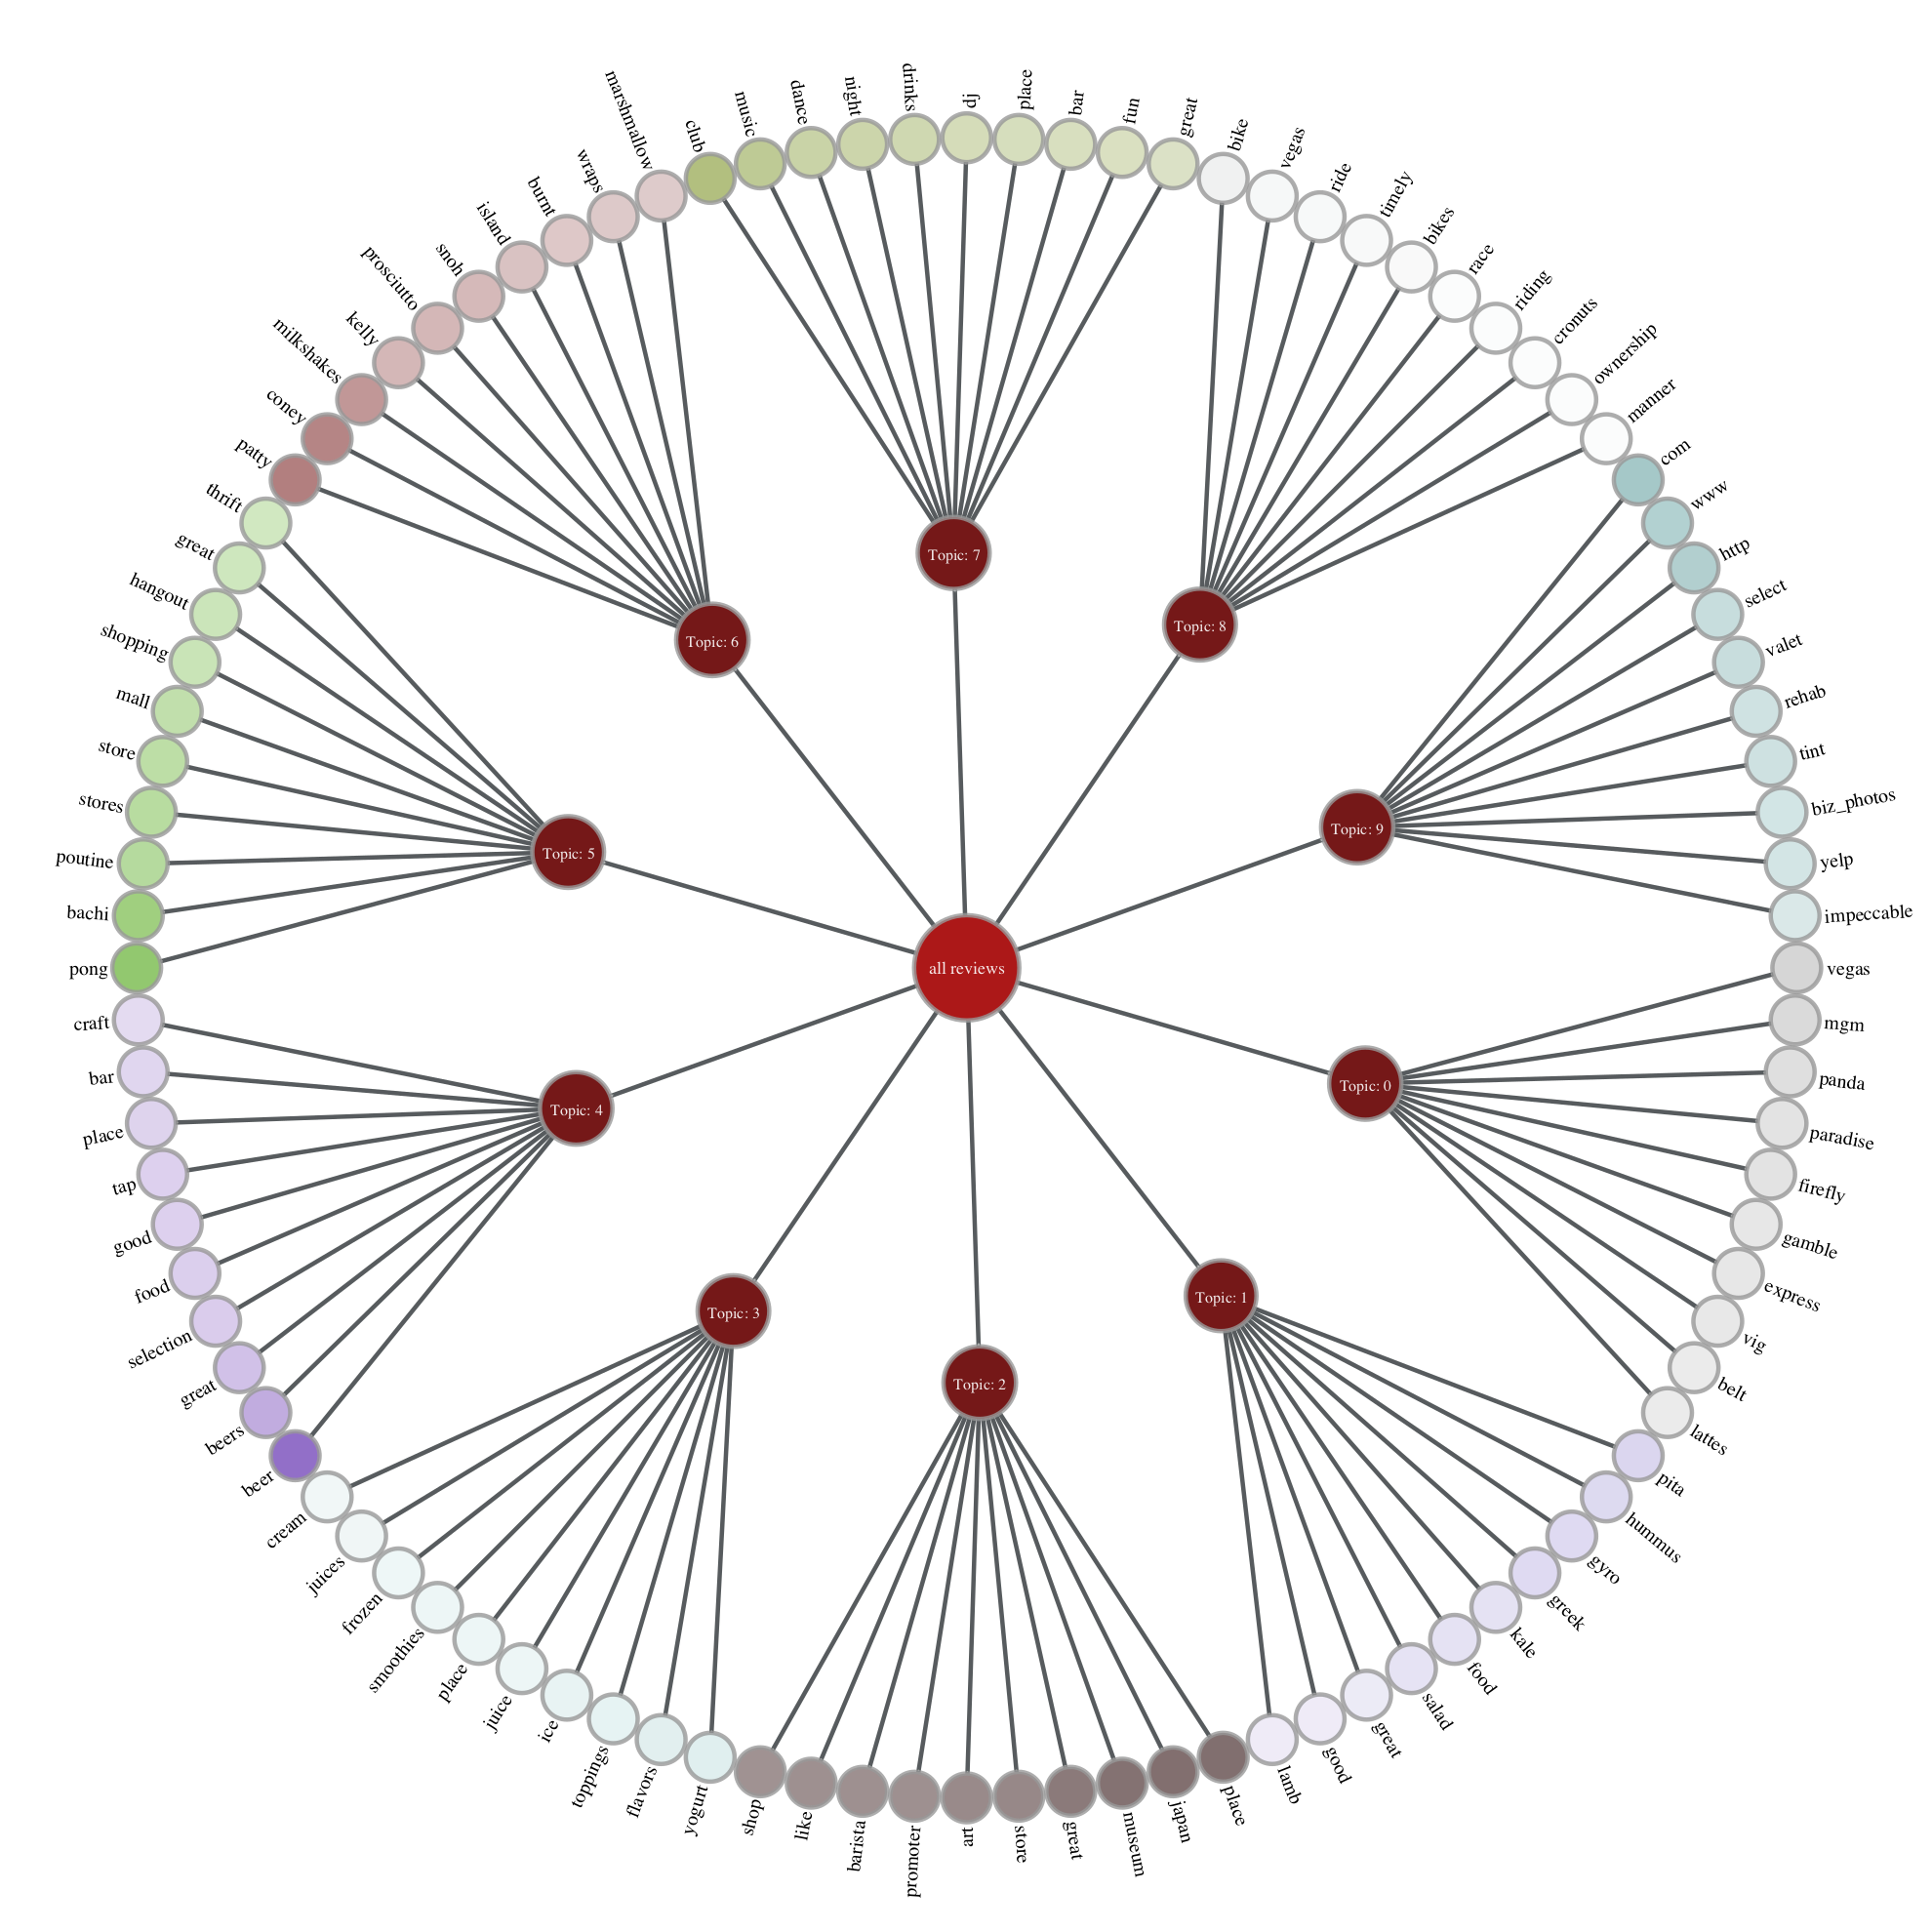

In [80]:
allReviewsViz = Visualization()

for i, item in enumerate(allReviewsLDA.show_topics(num_topics=10, num_words=10, formatted=False)):
    vtopic = allReviewsViz.add_topic("Topic: " + str(i))
    
    maxWeight = 0.0
    for weight, term in item:
        maxWeight = max(maxWeight, weight)
    
    for weight, term in item:
        allReviewsViz.add_term(vtopic, term, weight=weight / maxWeight)

allReviewsViz.draw("all_reviews.png")

The visualization of the above gives an idea of the first 10 Topics. The intensity of color depends on weight of each word in the topic. Based on words some topics can be clearly assigned to a specific area, for example Topic \#7 is obviously about night clubs: 'dj', 'drinks', 'nigth', 'dance', 'club', 'fun' and 'bar'. Topic \#4 contains words from bars specific lexic: 'bar', 'tap', 'craft', 'beer', 'beers'. Topic \#3 is more about beverages or ice while Topic \#1 can be assigned to dishes topic. 

Another visualization is built below. For this we use bar chart. Each topics presented as a sequence of bars and there is a gap between two topics. The visualization displayes how weights are expanded across first 10 words in each topic.

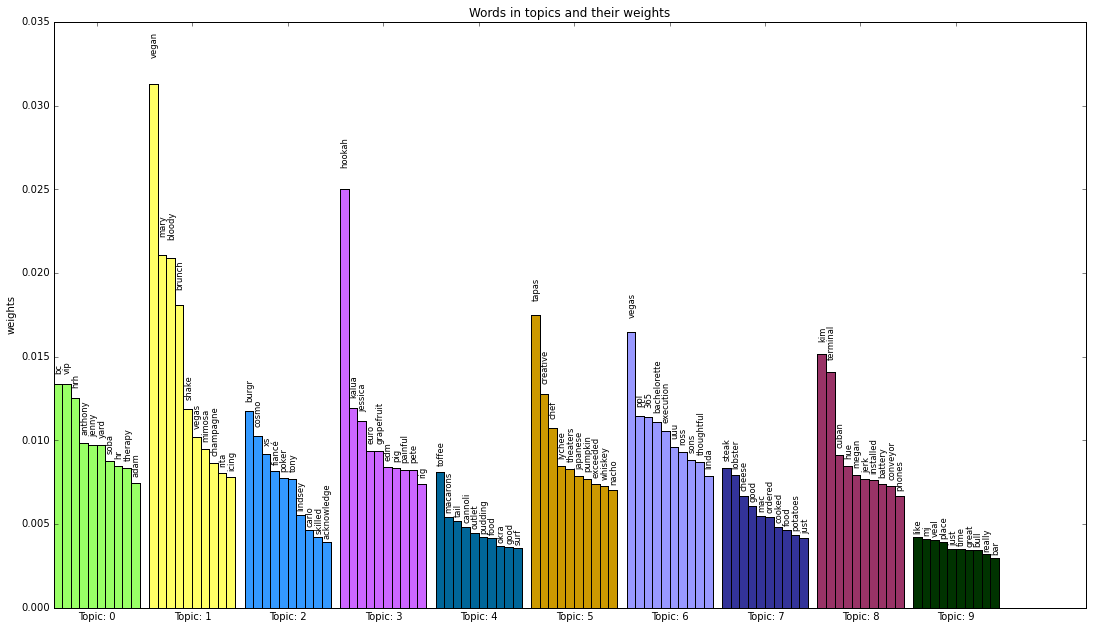

In [177]:
%matplotlib inline

import numpy as np
import matplotlib.pyplot as plt

num_topics=10
num_words=10

width = 0.5
gap_width = 0.55

fig, ax = plt.subplots()
colors = ['#99FF66', '#FFFF66', '#3399FF', '#CC66FF', '#006699', '#CC9900', '#9999FF', '#333399', '#993366', '#003300']

for i, item in enumerate(allReviewsLDA.show_topics(num_topics=num_topics, num_words=num_words, formatted=False)):   
    weights = [weight for weight, term in item]
    terms = [term for weight, term in item]
    
    term_start_idx = i * (num_words * width + gap_width)
    ind = [term_start_idx + j * width for j in range(0, num_words)] 
    
    bar = ax.bar(ind, weights, width, color=colors[i])

    j = 0
    for rect in bar:
        height = rect.get_height()
        ax.text(rect.get_x() + rect.get_width() / 1.5, height * 1.05, terms[j],
                ha='center', va='bottom', rotation='vertical', size='small')
        j += 1


ax.set_title('Words in topics and their weights')
ax.set_ylabel('weights')

topic_step = num_words * width
ax.set_xticks([topic_step / 2 + i * (topic_step + gap_width) for i in range(0, num_topics)])

ax.set_xticklabels(['Topic: ' + str(i) for i in range(0, num_topics)])

fig.set_size_inches(18.5, 10.5)
fig.savefig('all_reviews_bars.png', dpi=200)


plt.show()

## Probabilistic latent semantic analysis ##

Actually Probabilistic latent semantic analysis (pLSA) is it as simple as setting alpha and eta to 1 in used before LDA implementation. 

In [8]:
from gensim.matutils import Sparse2Corpus
from gensim.models.ldamulticore import LdaMulticore
from sklearn.feature_extraction.text import TfidfVectorizer

def buildPLSA(docs, num_features=50000, num_topics=50):
    vectorizer = TfidfVectorizer(max_df=0.5, max_features=num_features, min_df=2, stop_words='english', use_idf=True)
    vector = vectorizer.fit_transform(docs)
    
    id2words = {i:word for i,word in enumerate(vectorizer.get_feature_names())}
    
    corpus = Sparse2Corpus(vector,  documents_columns=False)
    plsa = LdaMulticore(corpus, id2word=id2words, num_topics=num_topics, 
                          chunksize=100, passes=1, alpha=1, eta=1)
    return plsa

In [9]:
allReviewsPLSA = buildPLSA(reviewsDF.select("text").map(lambda x: x.text).toLocalIterator())

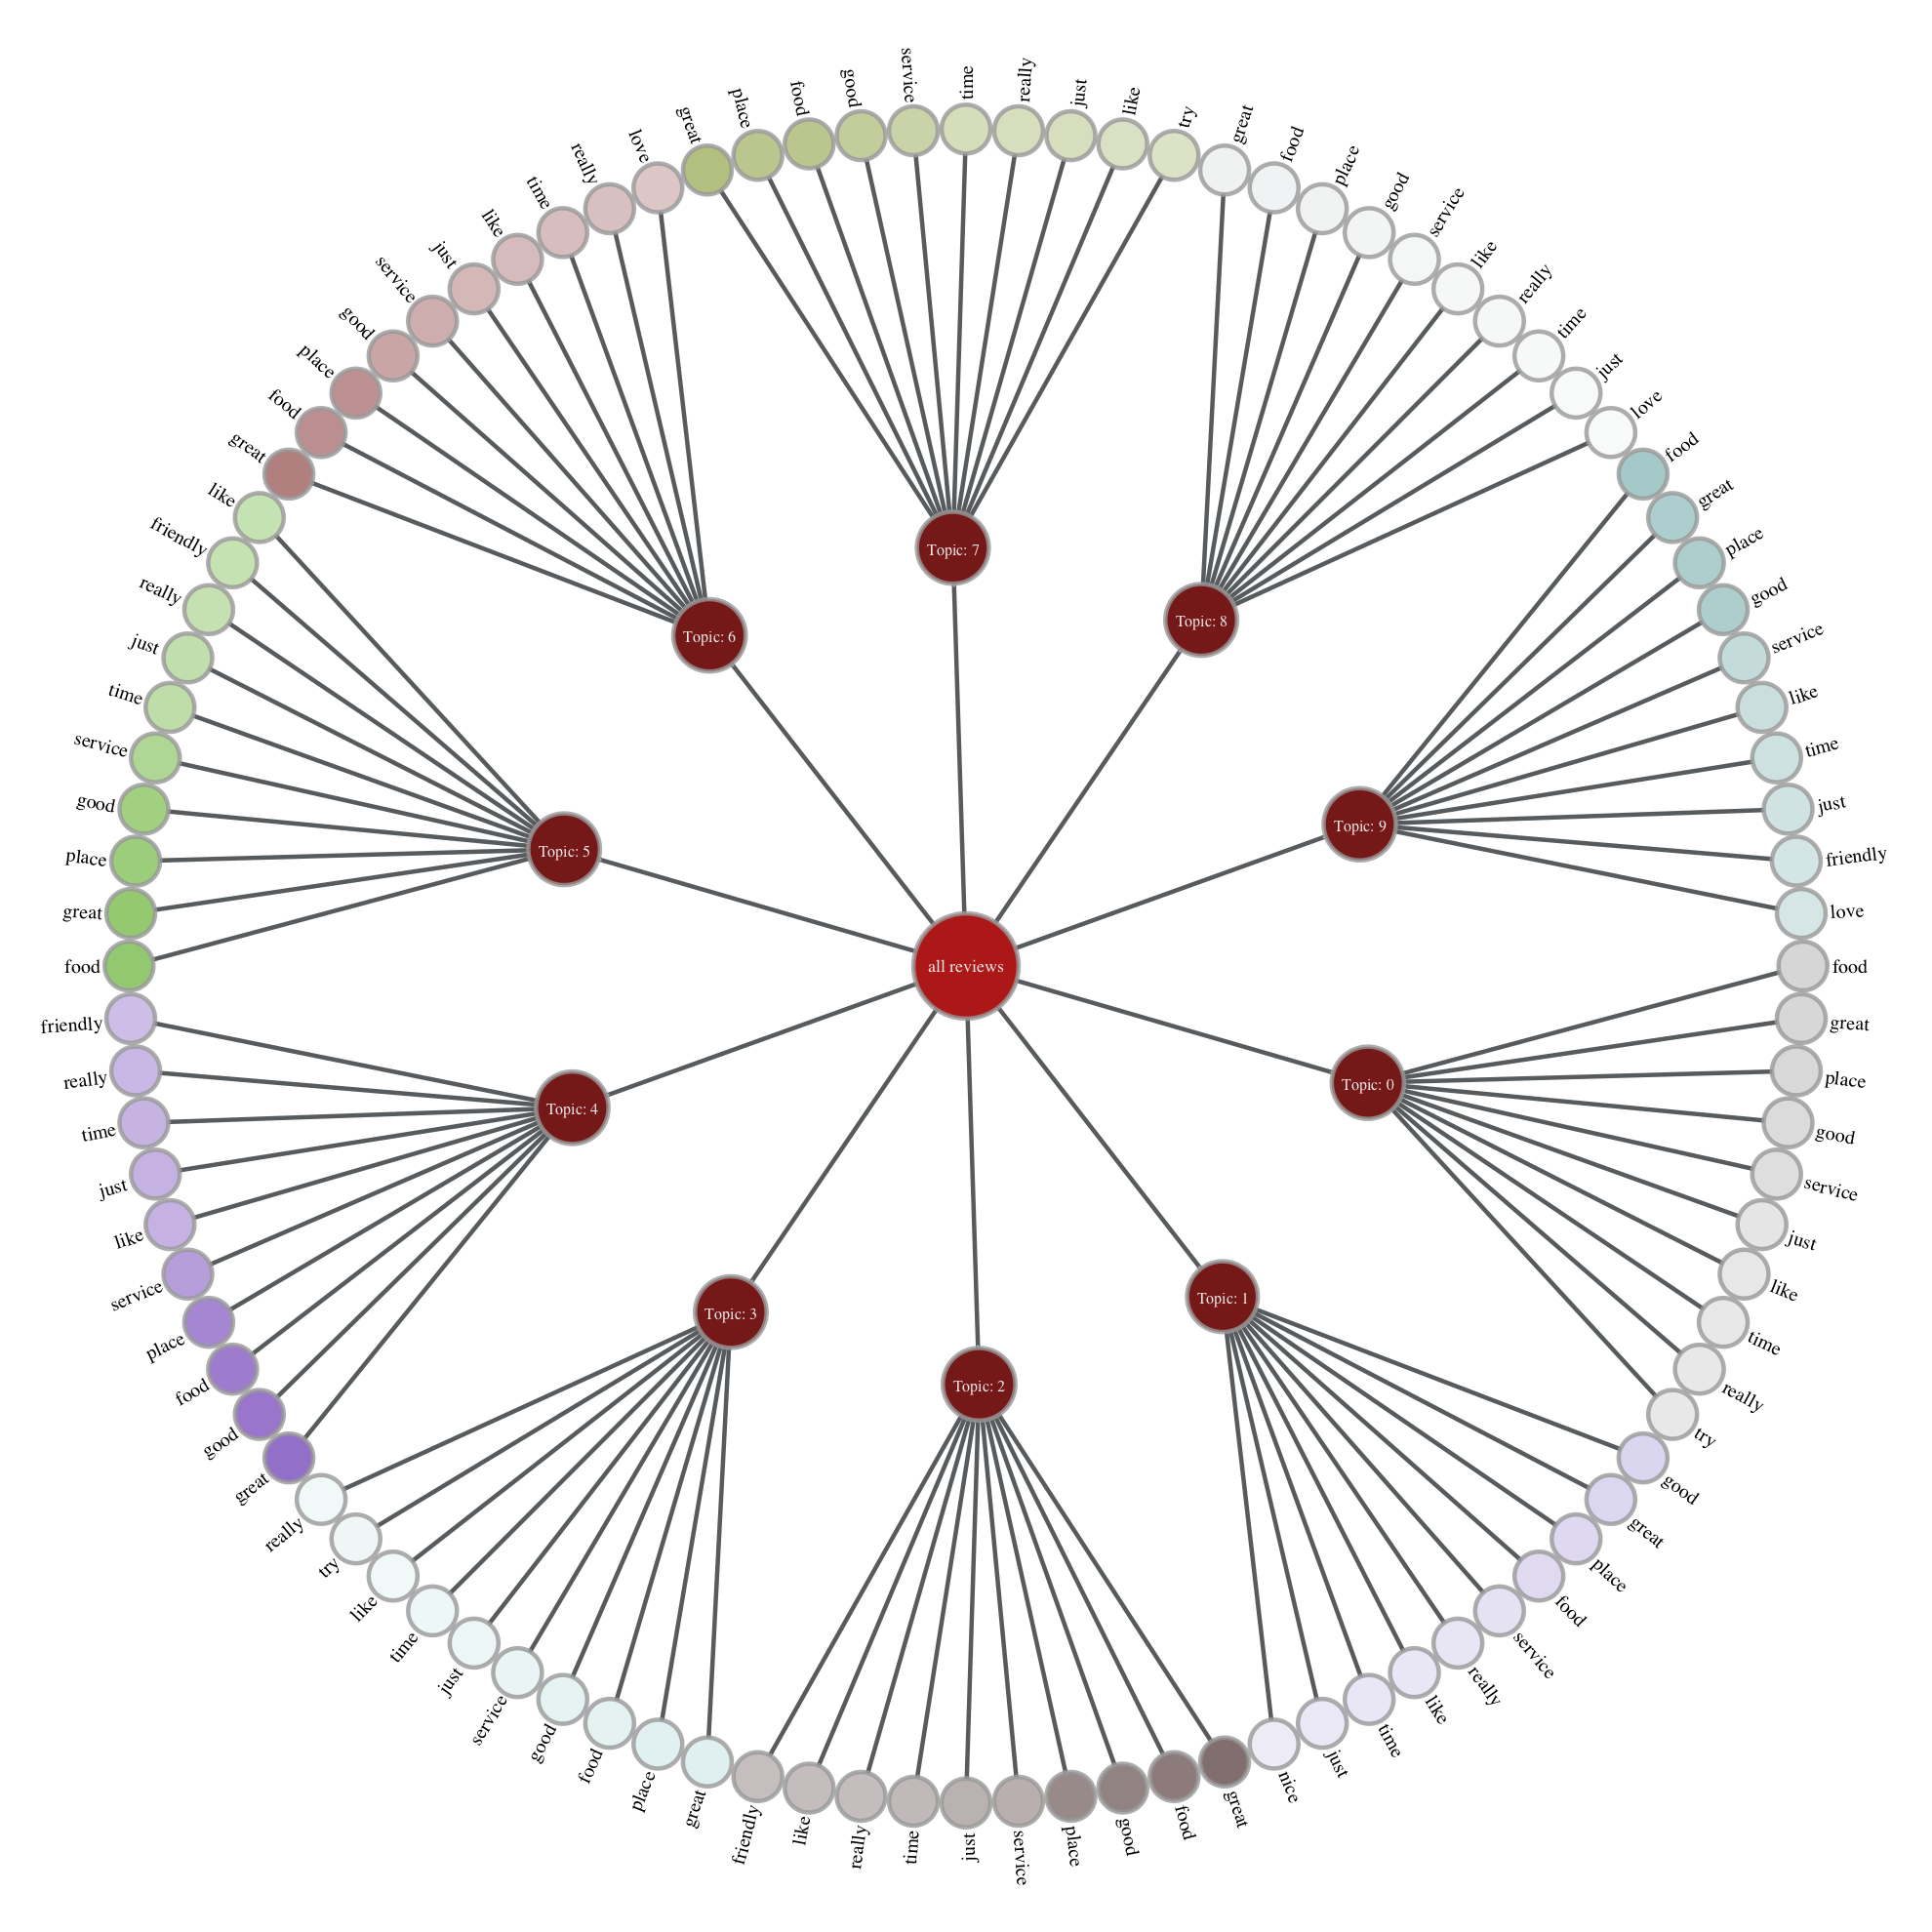

In [10]:
allReviewsPLSAViz = Visualization()

for i, item in enumerate(allReviewsPLSA.show_topics(num_topics=10, num_words=10, formatted=False)):
    vtopic = allReviewsPLSAViz.add_topic("Topic: " + str(i))
    
    maxWeight = 0.0
    for weight, term in item:
        maxWeight = max(maxWeight, weight)
    
    for weight, term in item:
        allReviewsPLSAViz.add_term(vtopic, term, weight=weight / maxWeight)

allReviewsPLSAViz.draw("all_reviews_plsa.pdf")

## Comparison of reviews with ratings of one star and five stars ##

Here we are going to make the same sequence of steps: filter data to create to sub-sets: one set of reviews with one star and the seond one with all five starts. Then we will build LDA and visualize date in order to find the differences between result for these two datasets.

In [16]:
excelentReviews = reviewsDF.filter(reviewsDF["stars"] == 5).select("text").map(lambda x: x.text).toLocalIterator()
badReviews = reviewsDF.filter(reviewsDF["stars"] == 1).select("text").map(lambda x: x.text).toLocalIterator()

In [17]:
excelentReviewsLDA = buildLDA(excelentReviews)

In [18]:
badReviewsLDA = buildLDA(badReviews)

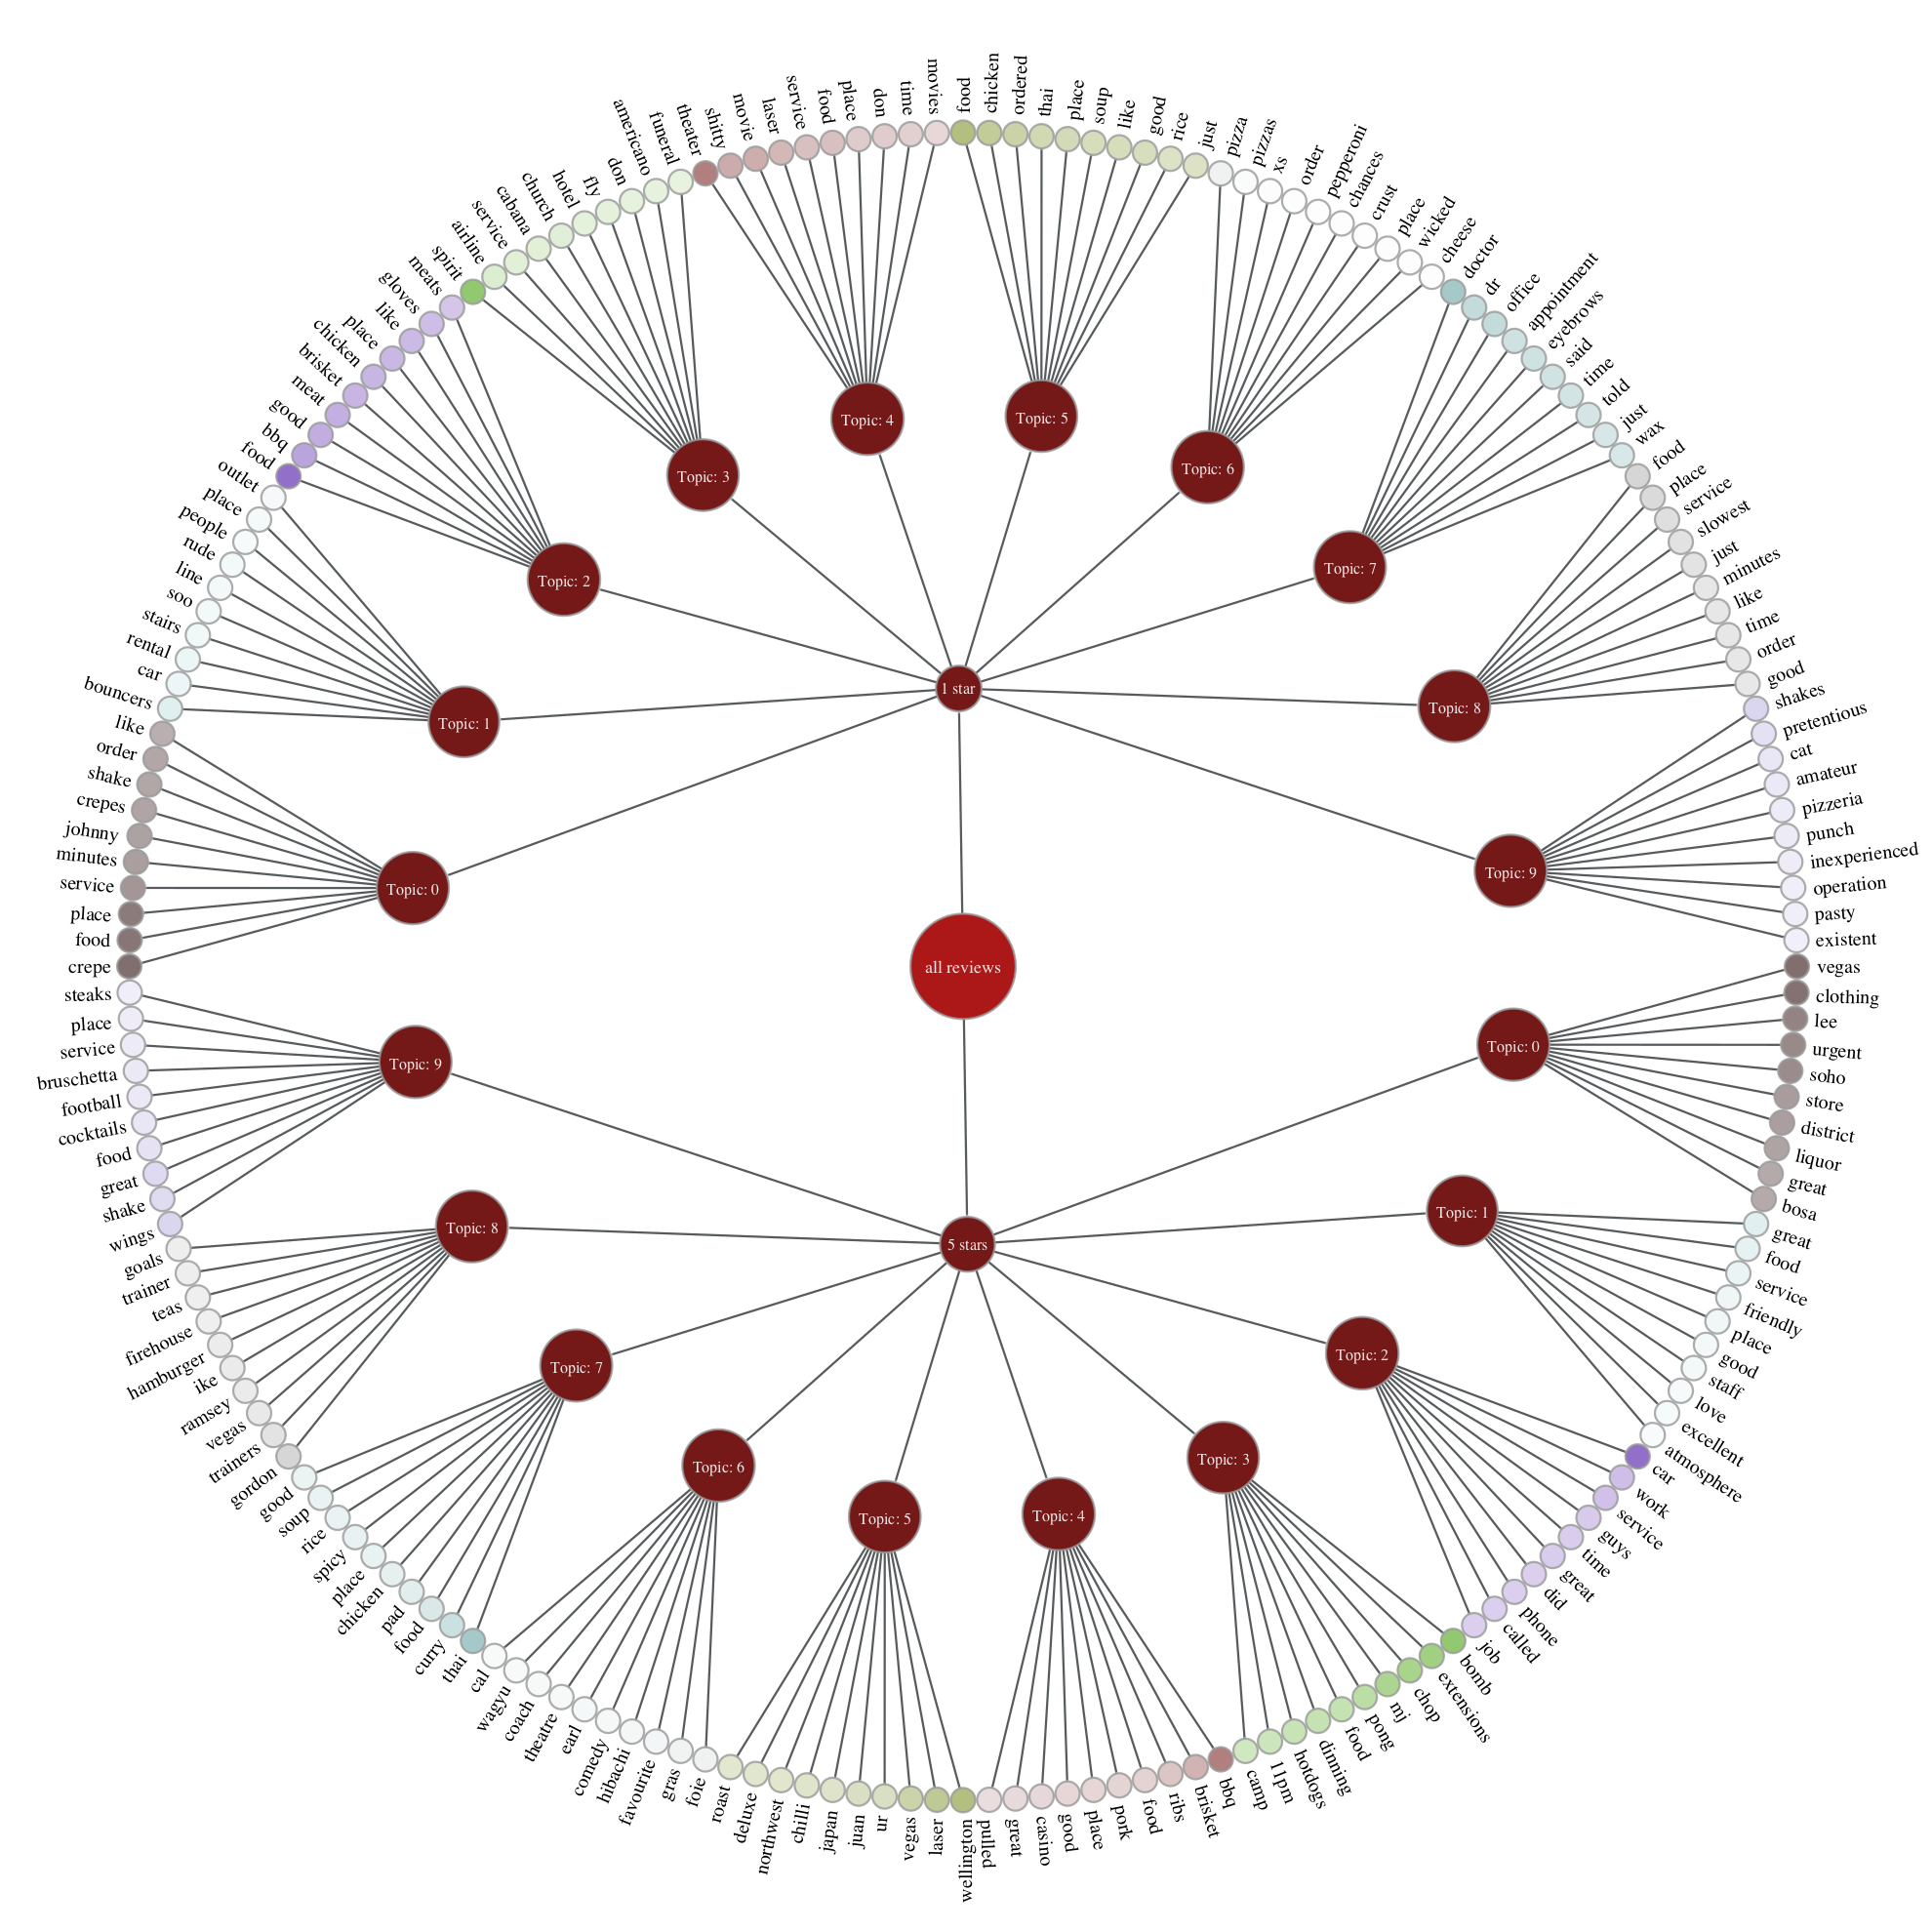

In [71]:
compViz = Visualization(term_count=200)

root1 = compViz.add_topic("5 stars")
root2 = compViz.add_topic("1 star")

for i, item in enumerate(excelentReviewsLDA.show_topics(num_topics=10, num_words=10, formatted=False)):
    vtopic = compViz.add_topic("Topic: " + str(i), root1)
    
    maxWeight = 0.0
    for weight, term in item:
        maxWeight = max(maxWeight, weight)
        
    for weight, term in item:
        compViz.add_term(vtopic, term, weight=weight / maxWeight, vertex_size=25)
        
for i, item in enumerate(badReviewsLDA.show_topics(num_topics=10, num_words=10, formatted=False)):
    vtopic = compViz.add_topic("Topic: " + str(i), root2)
   
    maxWeight = 0.0
    for weight, term in item:
        maxWeight = max(maxWeight, weight)
        
    for weight, term in item:
        compViz.add_term(vtopic, term, weight=weight / maxWeight, vertex_size=25)

compViz.draw("one_star_vs_five_starts.pdf")

In principle on the basis of a visual analysis we can to say that the quality of topics is about the same for reviews with one star compared to five stars reviews. The main difference that can be found is that words from five star reviews is a mix of general and positives adjectives, for instance, the topic \#4 there is words about food like 'bbq', 'ribs' and at the same time there are 'great' or 'good'. From low rating reviews a good example of statement above could be Topic \#9, food related words: 'shakes', 'pizzeria', 'pasty' and negative adjectives: 'inexperienced', 'pretentious'.

At the same time it is necessary to notice that low rated reviews still have positive adjectives as a part while we don't consider the same thing for high rated reviews. An example of this can be Topic \#2 from one star reviews, here we see restorant relatent lexic: 'bbq', 'meat' and positive words 'good', 'like'.

## Comparison of topics for restaurant reviews and doctor reviews ##
The next idea is to compare topics built only on restaurants reviews and filter out all other, for example reviews for SPA, shopping etc. 

In [52]:
from pyspark.sql.functions import udf, col, lit
from pyspark.sql.types import BooleanType

businessJSON = os.path.join(targetDir, 'yelp_academic_dataset_business.json')
businessDF = sqlContext.read.json(businessJSON)

contains = udf(lambda xs, val: val in xs, BooleanType())
restaurantsDF = businessDF[contains(businessDF.categories, lit("Restaurants"))]
shoppingDF = businessDF[contains(businessDF.categories, lit("Shopping"))]

restaurantReviewsDF = reviewsDF.join(restaurantsDF, restaurantsDF.business_id == reviewsDF.business_id)
shoppingReviewsDF = reviewsDF.join(shoppingDF, shoppingDF.business_id == reviewsDF.business_id)

restaurantReviews = restaurantReviewsDF.select("text").map(lambda x: x.text).toLocalIterator()
shoppingReviews = shoppingReviewsDF.select("text").map(lambda x: x.text).toLocalIterator()

In [53]:
restaurantReviewsLDA = buildLDA(restaurantReviews, num_topics=100)

In [54]:
shoppingReviewsLDA = buildLDA(shoppingReviews, num_topics=100)

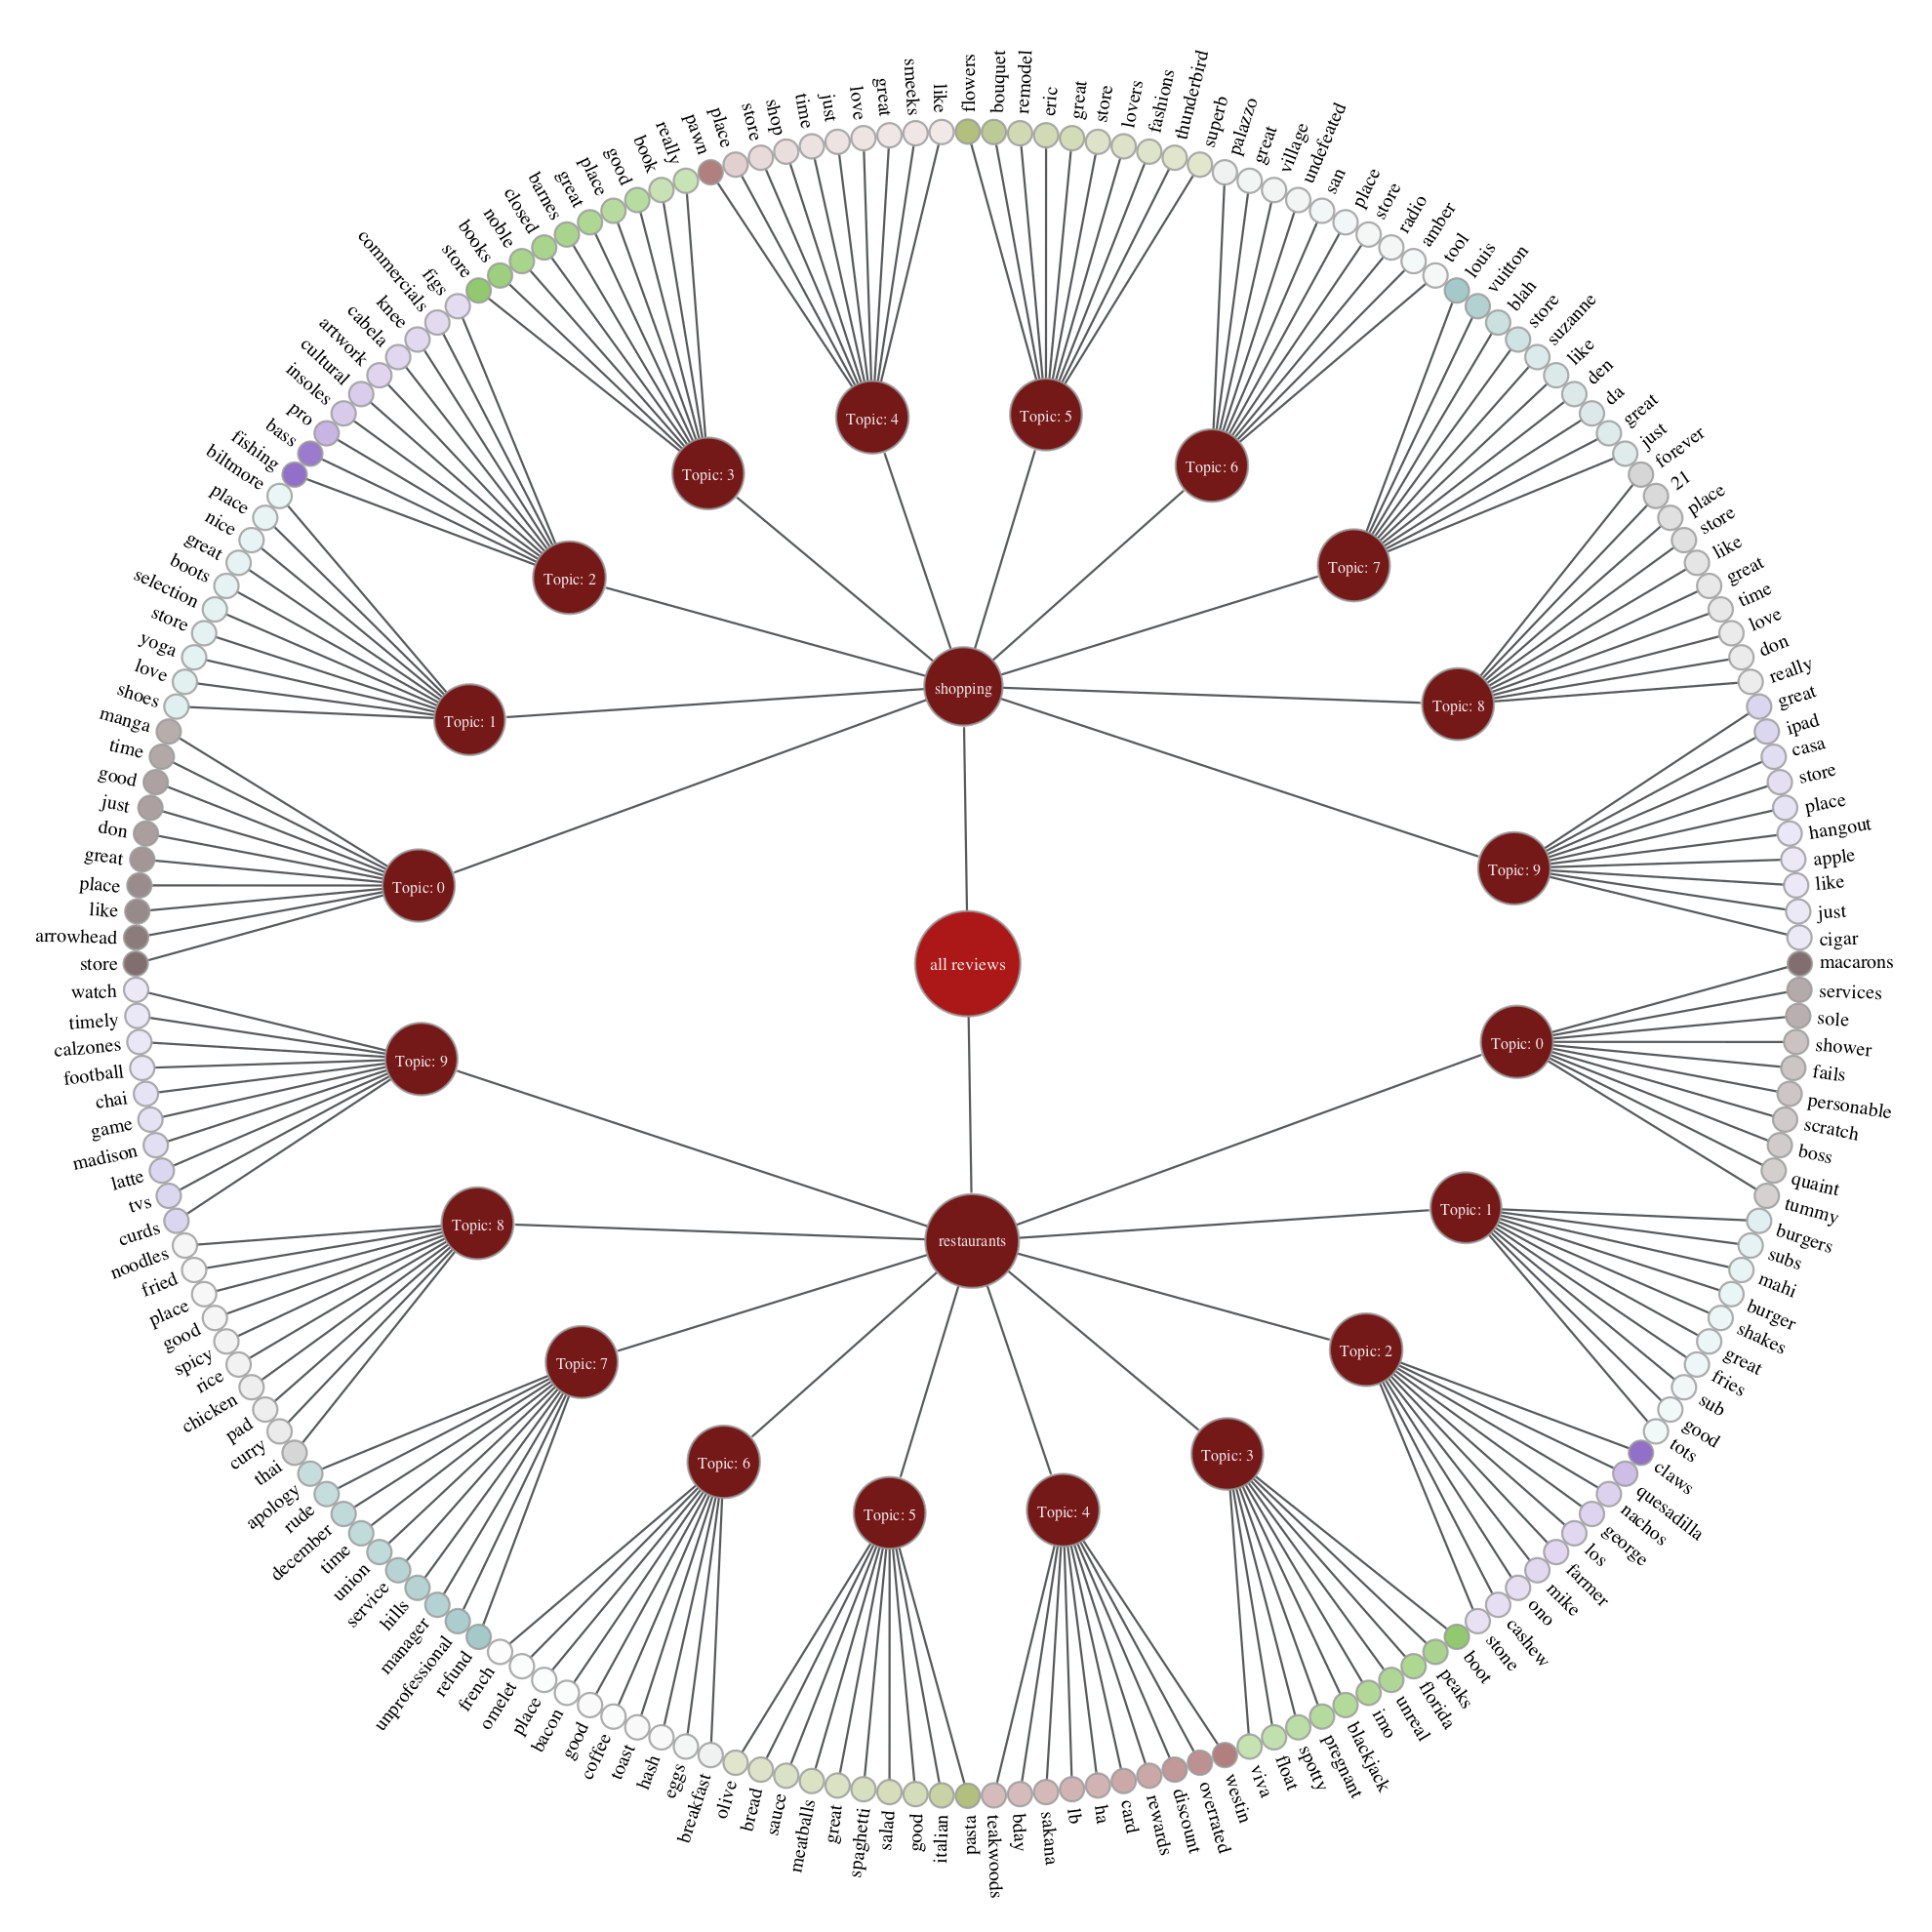

In [55]:
compDocVsRestViz = Visualization(term_count=200)

root1 = compDocVsRestViz.add_topic("restaurants")
root2 = compDocVsRestViz.add_topic("shopping")

for i, item in enumerate(restaurantReviewsLDA.show_topics(num_topics=10, num_words=10, formatted=False)):
    vtopic = compDocVsRestViz.add_topic("Topic: " + str(i), root1)
    
    maxWeight = 0.0
    for weight, term in item:
        maxWeight = max(maxWeight, weight)
    
    for weight, term in item:
        compDocVsRestViz.add_term(vtopic, term, weight=weight / maxWeight, vertex_size=25)
        
for i, item in enumerate(shoppingReviewsLDA.show_topics(num_topics=10, num_words=10, formatted=False)):
    vtopic = compDocVsRestViz.add_topic("Topic: " + str(i), root2)
    
    maxWeight = 0.0
    for weight, term in item:
        maxWeight = max(maxWeight, weight)
        
    for weight, term in item:
        compDocVsRestViz.add_term(vtopic, term, weight=weight / maxWeight, vertex_size=25)

compDocVsRestViz.draw("restaurants_vs_shopping.pdf")

Now let's compare topics in both sub-groups of reviews. Topics for shopping reviews are quite clear distributed by type of shops. Here we can see book store topic, this is Topic \#3 ('book', 'books', 'barnes', 'noble') or flower shops in Topic \#5 ('flowers', 'bouquet'). 

In turn, the topics based on restaurant reviews are distributed by type of cuisine or type of restaurant. Here we can see topic ralted to italian food (Topic \#5: 'pasta', italian', 'meatballs', 'sauce', 'olive', 'bread') or tai cuisine (Topic \#0: 'tai', 'carry', 'pad', 'chiken', 'rice', 'spicy', 'noodles').